In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.utils.data import DataLoader, Subset
import gzip
import os
from scipy.stats import wasserstein_distance  # EMD calculation
from collections import defaultdict, Counter
import glob
from collections import Counter
from scipy.spatial.distance import jensenshannon

### Data Partitioning


In [3]:
def load_data_from_disk(partition_id: int, only_server_test_data: bool = False):
    #save_dir = "../data/client_dataset"
    save_dir = "/content/drive/MyDrive/FYP/Implementations/dataset/client_data_set"
    BATCH_SIZE = 64

    if only_server_test_data:
        testset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
            ])
        )
        return DataLoader(testset, batch_size=BATCH_SIZE)

    client_filenames = [
        os.path.join(save_dir, f'client_{partition_id}.pt.gz'),
        os.path.join(save_dir, f'iid_clients_{partition_id}.pt.gz')
    ]
    for path in client_filenames:
        if os.path.exists(path):
            partition_data_path = path
            break
    else:
        raise FileNotFoundError(f"No data file for client {partition_id}")

    with gzip.open(partition_data_path, 'rb') as f:
        device_data = torch.load(f, map_location='cpu')
    device_data = [(x.to(torch.float32), y) for x,y in device_data]
    np.random.shuffle(device_data)
    split = int(len(device_data)*0.8)
    train_data, test_data = device_data[:split], device_data[split:]

    normalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    train_data = [(normalize(x), y) for x,y in train_data]
    test_data  = [(normalize(x), y) for x,y in test_data]

    trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    valloader  = DataLoader(test_data,  batch_size=BATCH_SIZE)
    return trainloader, valloader

In [4]:
# Parameters
FL_ROUNDS = 100
LOCAL_EPOCHS = 6
NUM_CLIENTS = 50

In [5]:
client_dataset_list = []
for i in range(NUM_CLIENTS):
    trainloader, valloader = load_data_from_disk(i)
    client_dataset_list.append((trainloader, valloader))

In [ ]:
#import pickle

#with open('/content/drive/MyDrive/FYP/Implementations/client_dataset_50.pkl', 'wb') as f:
#    pickle.dump(client_dataset_list, f)

## Model

In [6]:
# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 8, 8]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 4, 4]
        x = x.view(-1, 128 * 4 * 4)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## CLient

In [7]:
class Client:

    def __init__(self, id):
        self.id = id
        #self.trainloader, self.valloader = self.load_client_dataset_from_disk(id)
        self.trainloader, self.valloader = client_dataset_list[id]

    def load_client_dataset_from_disk(self, client_id: int):
        save_dir = "/content/drive/MyDrive/Engineering-UOR/Final Year Project/Implementations/data/client_data_set"
        BATCH_SIZE = 64

        client_filenames = [
            os.path.join(save_dir, f'client_{client_id}.pt.gz'),
            os.path.join(save_dir, f'iid_clients_{client_id}.pt.gz')
        ]
        for path in client_filenames:
            if os.path.exists(path):
                partition_data_path = path
                break
        else:
            raise FileNotFoundError(f"No data file for client {client_id}")

        with gzip.open(partition_data_path, 'rb') as f:
            device_data = torch.load(f, map_location='cpu')

        device_data = [(x.to(torch.float32), y) for x, y in device_data]
        np.random.shuffle(device_data)
        split = int(len(device_data) * 0.8)
        train_data, test_data = device_data[:split], device_data[split:]

        normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        train_data = [(normalize(x), y) for x, y in train_data]
        test_data = [(normalize(x), y) for x, y in test_data]

        trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(test_data, batch_size=BATCH_SIZE)
        return trainloader, valloader

    def calculate_label_distribution(self):
        all_labels = []
        for _, labels in self.trainloader:
            all_labels.extend(labels.tolist())
        for _, labels in self.valloader:
            all_labels.extend(labels.tolist())

        label_counts = Counter(all_labels)
        for i in range(10):
            label_counts.setdefault(i, 0)
        sorted_distribution = dict(sorted(label_counts.items()))
        return sorted_distribution

    def calculate_emd(self, client_dist, reference_dist):
        client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
        reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

        client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
        reference_probs = reference_counts / reference_counts.sum()

        labels = np.arange(10)
        emd = wasserstein_distance(labels, labels, u_weights=client_probs, v_weights=reference_probs)
        return emd

    def calculate_js_divergence(self, client_dist, reference_dist):
        client_counts = np.array([client_dist[i] for i in range(10)], dtype=np.float32)
        reference_counts = np.array([reference_dist[i] for i in range(10)], dtype=np.float32)

        client_probs = client_counts / client_counts.sum() if client_counts.sum() > 0 else np.zeros_like(client_counts)
        reference_probs = reference_counts / reference_counts.sum()

        return jensenshannon(client_probs, reference_probs, base=2.0) ** 2

    def train_local(self, global_model, epochs, device):
        model = copy.deepcopy(global_model).to(device)
        model.train()
        optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            total_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in self.trainloader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

            avg_loss = total_loss / total
            accuracy = 100. * correct / total
            print(f"Client {self.id} Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2f}%")

        return model.state_dict()


## Server

In [8]:
class Server:

    def __init__(self, model):
        self.model = model

    # FedAvg Algorithm
    def fed_avg(self, client_models_param_list):
        avg_params = copy.deepcopy(client_models_param_list[0])
        for key in avg_params:
            for i in range(1, len(client_models_param_list)):
                avg_params[key] += client_models_param_list[i][key]
            avg_params[key] /= len(client_models_param_list)
        return avg_params

    # Weighted FedAvg
    def weighted_fed_avg(self, models_params, weights):
        avg_params = copy.deepcopy(models_params[0])
        total_weight = sum(weights)
        for param_key in avg_params:
            weighted_sum = torch.zeros_like(avg_params[param_key])
            for i in range(len(models_params)):
                client_param = models_params[i][param_key]
                weighted_sum += client_param * weights[i]
            avg_params[param_key] = weighted_sum / total_weight
        return avg_params

    # Assign Weight For Clients based on IID nature mesures (EMD/JS/..)
    def emd_to_weights(self, client_emd_list):
        d_min, d_max = min(client_emd_list), max(client_emd_list)
        if d_max == d_min:
            return [1.0 for _ in client_emd_list]  # Avoid div by zero
        return [(1 - (emd - d_min) / (d_max - d_min)) for emd in client_emd_list]

    # Aggregation
    def aggregate_models(self, client_models, weights=None):
        if weights is None:
            aggregated_model_params = self.fed_avg(client_models)
        else:
            aggregated_model_params = self.weighted_fed_avg(client_models, weights)
        self.model.load_state_dict(aggregated_model_params)
        return self.model

    # Test Global Model
    def test_model(self, testloader, device):
        self.model.eval()
        correct, total = 0, 0
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)  # FIXED: self.model
                loss = criterion(outputs, labels)
                total_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_loss = total_loss / total
        accuracy = 100.0 * correct / total
        return accuracy, avg_loss


## Federated Training Loop

In [9]:
global_testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/FYP/Implementations/dataset', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
global_testset_loader = DataLoader(global_testset, batch_size=64)

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


In [10]:
# Initialize global model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model = Net().to(device)

server = Server(global_model)

global_accuracy_list = []
global_loss_list = []

for fl_round in range(FL_ROUNDS):
    print(f"\n--- Federated Learning Round {fl_round + 1} ---")

    clients_model_param_list = []
    client_dist_list = []
    client_emd_list = []
    client_js_list = []

    for i in range(NUM_CLIENTS):

        client = Client(i)  # Load client data

        print(f"\n Client {i}: Local Training")
        print("--------------------------------------------------")

        # Client Local Training
        local_model_params = client.train_local(
            global_model, epochs=LOCAL_EPOCHS, device=device
        )
        clients_model_param_list.append(local_model_params)


    # Aggregation
    server.aggregate_models(client_models=clients_model_param_list)

    # Evaluate Global Model
    accuracy, loss = server.test_model(testloader=global_testset_loader, device=device)
    global_accuracy_list.append(accuracy)
    global_loss_list.append(loss)

    print(f"\nFederated Learning Round {fl_round + 1}:")
    print(f"  Accuracy: {accuracy:.2f}%, Loss: {loss:.4f}")


Streaming output truncated to the last 5000 lines.
Client 0 Epoch 1: Loss = 0.0878, Accuracy = 97.24%
Client 0 Epoch 2: Loss = 0.0277, Accuracy = 99.11%
Client 0 Epoch 3: Loss = 0.0201, Accuracy = 99.21%
Client 0 Epoch 4: Loss = 0.0280, Accuracy = 98.92%
Client 0 Epoch 5: Loss = 0.0307, Accuracy = 99.21%
Client 0 Epoch 6: Loss = 0.0266, Accuracy = 99.21%

 Client 1: Local Training
--------------------------------------------------
Client 1 Epoch 1: Loss = 0.1834, Accuracy = 94.86%
Client 1 Epoch 2: Loss = 0.2246, Accuracy = 92.85%
Client 1 Epoch 3: Loss = 0.0994, Accuracy = 95.98%
Client 1 Epoch 4: Loss = 0.0641, Accuracy = 97.75%
Client 1 Epoch 5: Loss = 0.0261, Accuracy = 99.12%
Client 1 Epoch 6: Loss = 0.0162, Accuracy = 99.60%

 Client 2: Local Training
--------------------------------------------------
Client 2 Epoch 1: Loss = 0.1369, Accuracy = 96.46%
Client 2 Epoch 2: Loss = 0.0502, Accuracy = 98.31%
Client 2 Epoch 3: Loss = 0.1181, Accuracy = 97.19%
Client 2 Epoch 4: Loss = 0.1

### Plot Accuracy Curve

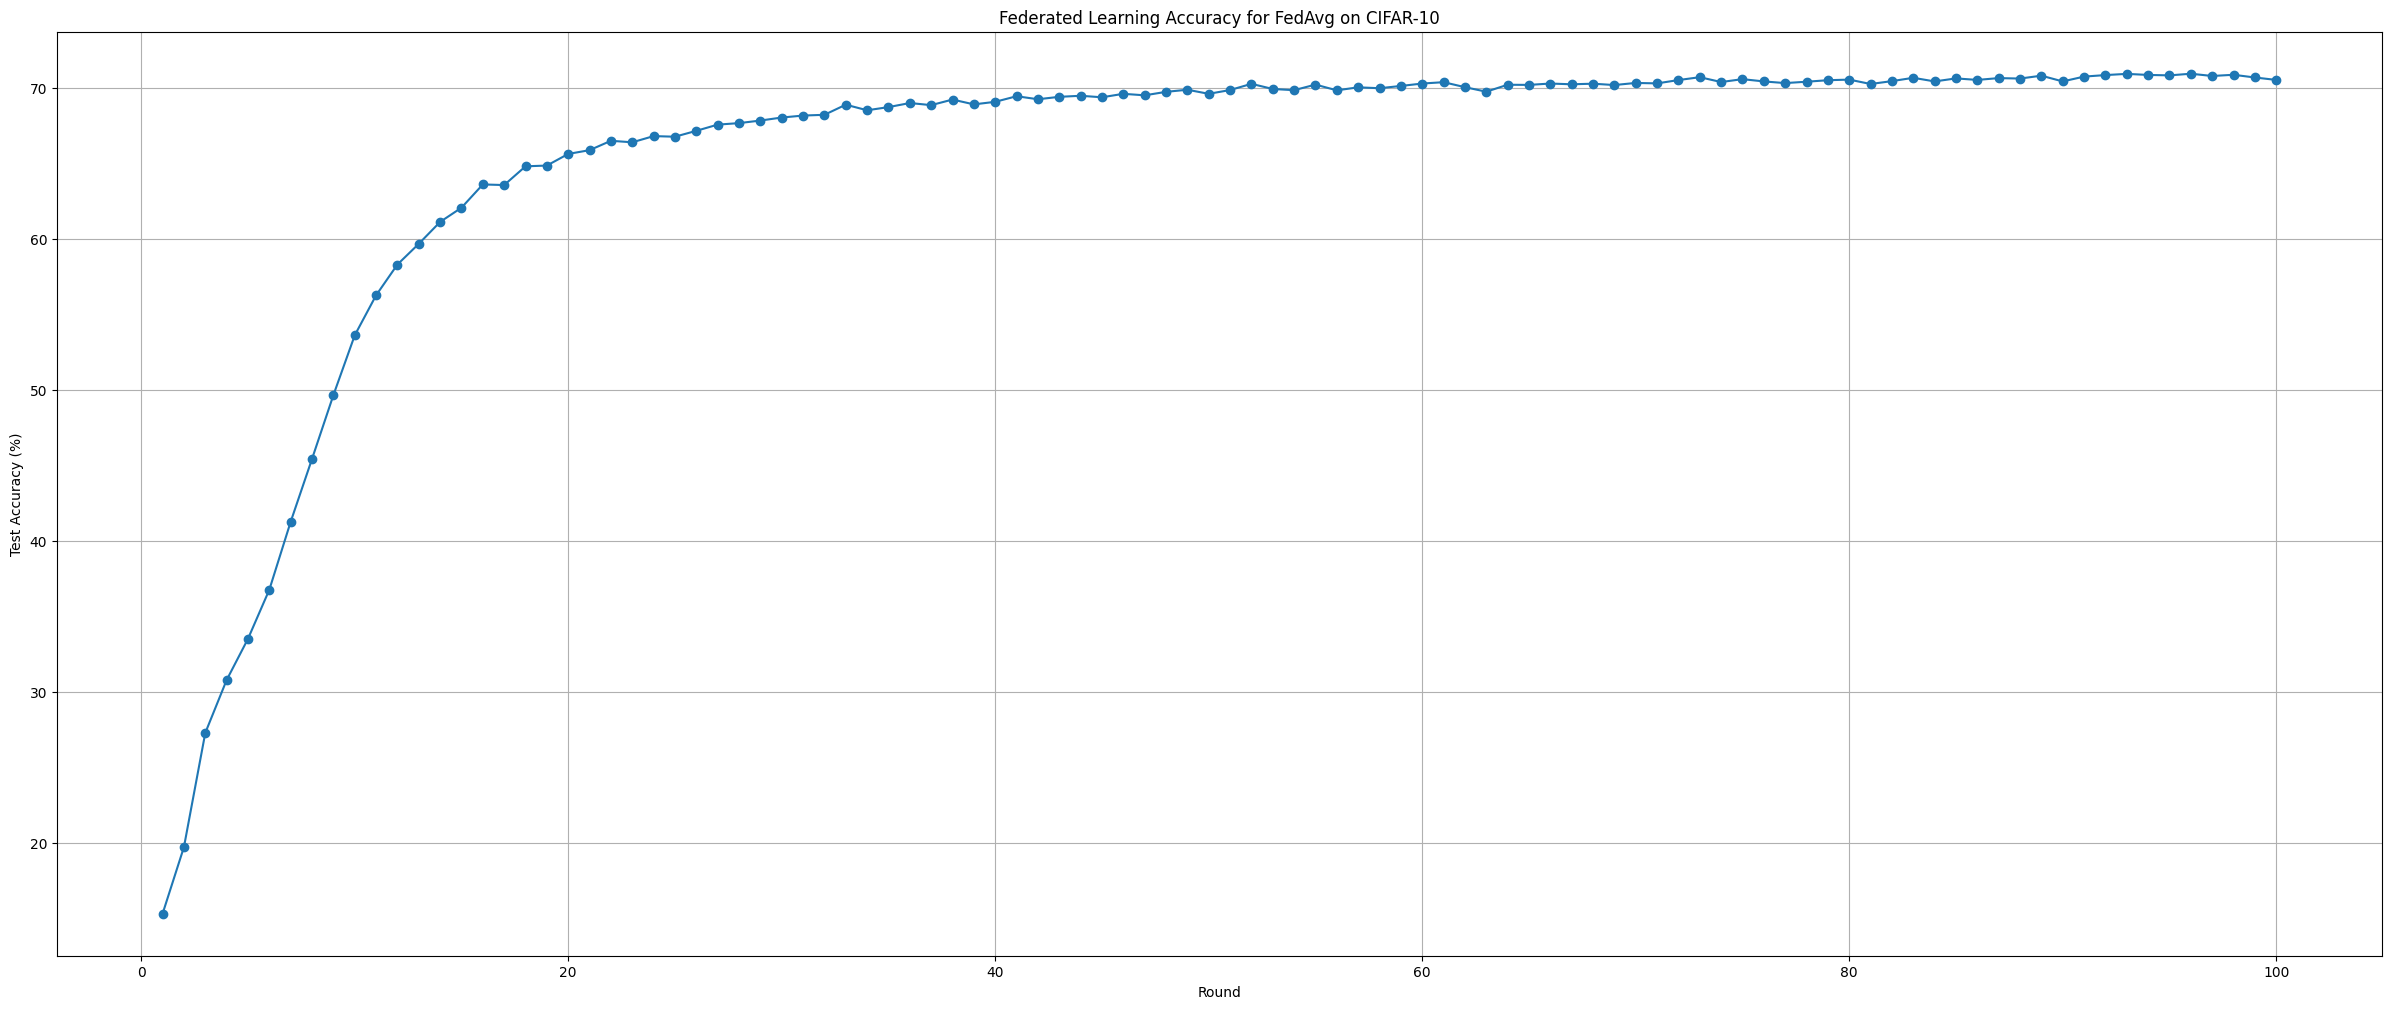

In [22]:

plt.figure(figsize=(30, 12))
plt.plot(range(1, FL_ROUNDS + 1), global_accuracy_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Test Accuracy (%)')
plt.title('Federated Learning Accuracy for FedAvg on CIFAR-10')
plt.grid(True)
#plt.xticks(range(1, 101))  # Set x-axis from 1 to 20
plt.show()

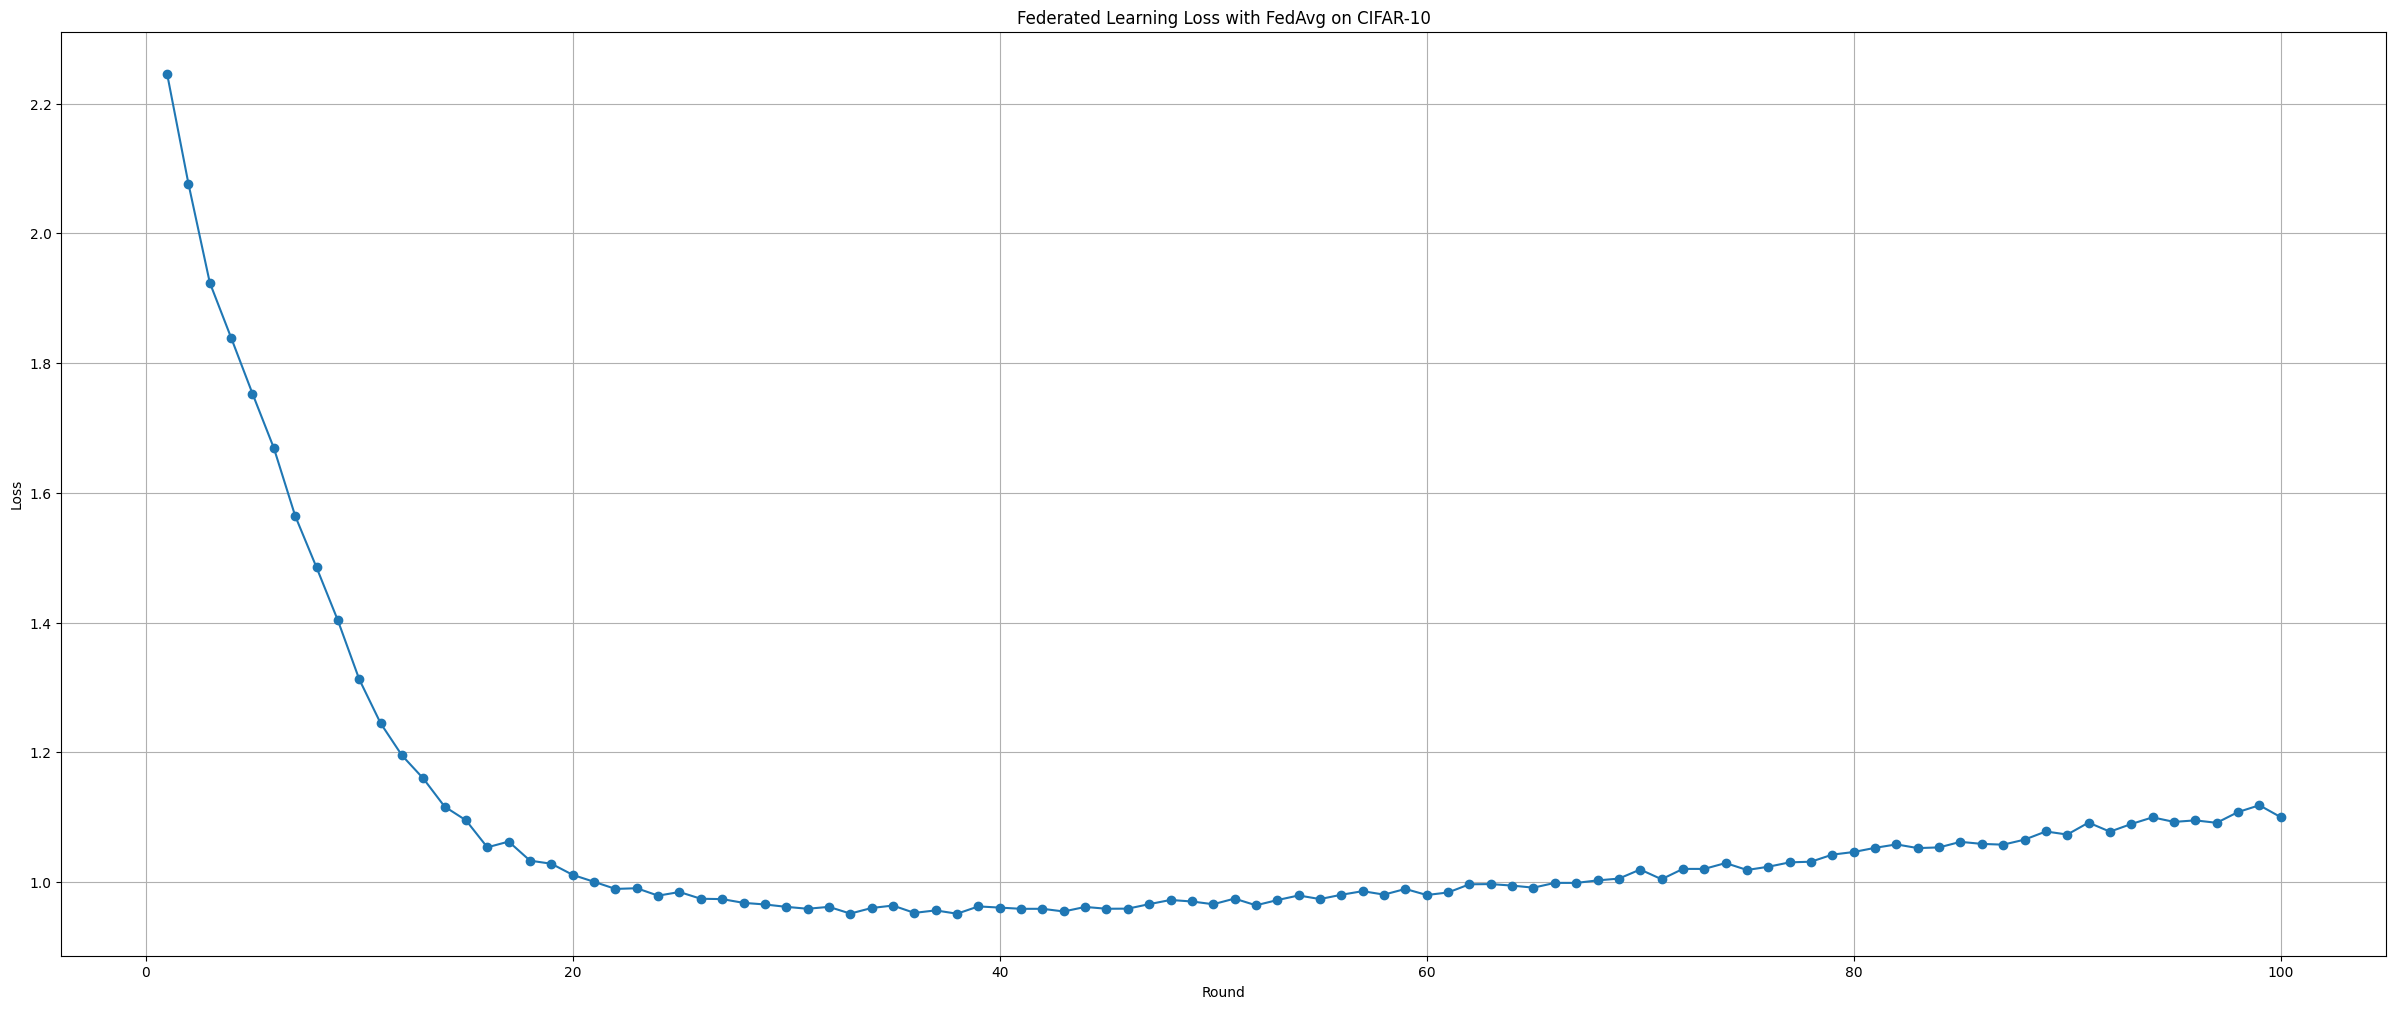

In [23]:
plt.figure(figsize=(30, 12))
plt.plot(range(1, FL_ROUNDS + 1), global_loss_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Federated Learning Loss with FedAvg on CIFAR-10')
plt.grid(True)
#plt.xticks(range(1, 101))  # Set x-axis from 1 to 20
plt.show()

In [13]:
import pickle

with open('/content/drive/MyDrive/FYP/Implementations/history/fedavg/accuracy_history_FL100.pkl', 'wb') as f:
    pickle.dump(global_accuracy_list, f)

with open('/content/drive/MyDrive/FYP/Implementations/history/fedavg/loss_history_FL100.pkl', 'wb') as f:
  pickle.dump(global_loss_list, f)